## Dataset link
https://www.kaggle.com/datasets/shreyashgupta88/american-sign-language-thresholded

In [1]:
#Imports

import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time

import os
import shutil
import pathlib
from importlib import reload
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

In [2]:
print(torch.__version__)

2.3.1+cu121


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Base Dataset

### Data Preparation for Base Dataset

In [4]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
DATASET_PATH = 'signs'
BATCH_SIZE = 32
EPOCHS = 10



path_dest = os.path.join('dataset')
train_path_dest = os.path.join(path_dest, 'trainSet')
validation_path_dest = os.path.join(path_dest, 'validSet')
test_path_dest = os.path.join(path_dest, 'testSet')

In [5]:
# function to separate the dataset into training, validation and test sets on another 3 folders. 
# It is assumed that the dataset is divided into classes
def separate_dataset(DATASET_PATH, train_path_dest, validation_path_dest, test_path_dest, train_split=0.6, validation_split=0.2, test_split=0.2):
    if not os.path.exists(DATASET_PATH):
        print('The dataset folder does not exist')
        return
    
    if(train_split < 0 or train_split > 1 or validation_split < 0 or validation_split > 1 or test_split < 0 or test_split > 1):
        print('One of the splits is less than or equal to 0 or greater than 1')
        return
    
    # create the folders if they don't exist
    if not os.path.exists(train_path_dest) and train_split > 0:
        os.makedirs(train_path_dest)
    if not os.path.exists(validation_path_dest) and validation_split > 0:
        os.makedirs(validation_path_dest)
    if not os.path.exists(test_path_dest) and test_split > 0:
        os.makedirs(test_path_dest)

    # get the list of files in the dataset
    files = os.listdir(DATASET_PATH)

    for class_name in files:
        # get the list of files in the class
        class_files = os.listdir(os.path.join(DATASET_PATH, class_name))
        # get the number of files in the class
        num_files = len(class_files)
        # calculate the number of files for each set
        num_train_files = int(num_files * train_split)
        num_validation_files = int(num_files * validation_split)
        num_test_files = num_files - num_train_files - num_validation_files
        
        abc = 'abcdefghijklmnopqrstuvwxyz'
        
        if not os.path.exists(os.path.join(train_path_dest, abc[int(class_name)])):
            os.makedirs(os.path.join(train_path_dest, abc[int(class_name)]))
        
        if not os.path.exists(os.path.join(validation_path_dest, abc[int(class_name)])):
            os.makedirs(os.path.join(validation_path_dest, abc[int(class_name)]))
        
        if not os.path.exists(os.path.join(test_path_dest, abc[int(class_name)])):
            os.makedirs(os.path.join(test_path_dest, abc[int(class_name)]))
        
        for i in range(num_files):
            # select a random file from the class
            file = class_files[np.random.randint(num_files)]
            num_files -= 1
            # remove the file from the list, but not from the original folder
            class_files.remove(file)
            fType = file.split('.')[-1]
            
            if i < num_train_files:
                shutil.copyfile(os.path.join(DATASET_PATH, class_name, file), os.path.join(train_path_dest, abc[int(class_name)], f'{i}.{fType}'))
            
            elif i < num_train_files + num_validation_files:
                shutil.copyfile(os.path.join(DATASET_PATH, class_name, file), os.path.join(validation_path_dest, abc[int(class_name)], f'{i-num_train_files}.{fType}'))
            else:
                shutil.copyfile(os.path.join(DATASET_PATH, class_name, file), os.path.join(test_path_dest, abc[int(class_name)], f'{i-num_train_files-num_validation_files}.{fType}'))
                
                
def remove_directories(folders):
    for folder in folders:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        else:
            print(f'The folder "{folder}" does not exist')

In [17]:
# use this to create the training, validation and test sets, for the base dataset
separate_dataset(DATASET_PATH, train_path_dest, validation_path_dest, test_path_dest, 0.7,0.2,0.1)

In [13]:
# use this to remove the training, validation and test sets, for the base dataset
remove_directories([path_dest])

In [6]:
# original images are 256x256, with 3 channels (RGB, although they appear to be grayscale).
# make the images grayscale, resize them to 28x28. I resized to this size because my device is not that powerful
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=NUM_CHANNELS),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor()
])

train_set = torchvision.datasets.ImageFolder(root=train_path_dest, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

validation_set = torchvision.datasets.ImageFolder(root=validation_path_dest, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE)

test_set = torchvision.datasets.ImageFolder(root=test_path_dest, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
print(train_set.classes)
print(validation_set.classes)
print(test_set.classes)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
reload(vcpi_util)

<module 'vcpi_util' from 'c:\\Users\\User\\Desktop\\VC_INDIVIDUAL\\util\\vcpi_util.py'>

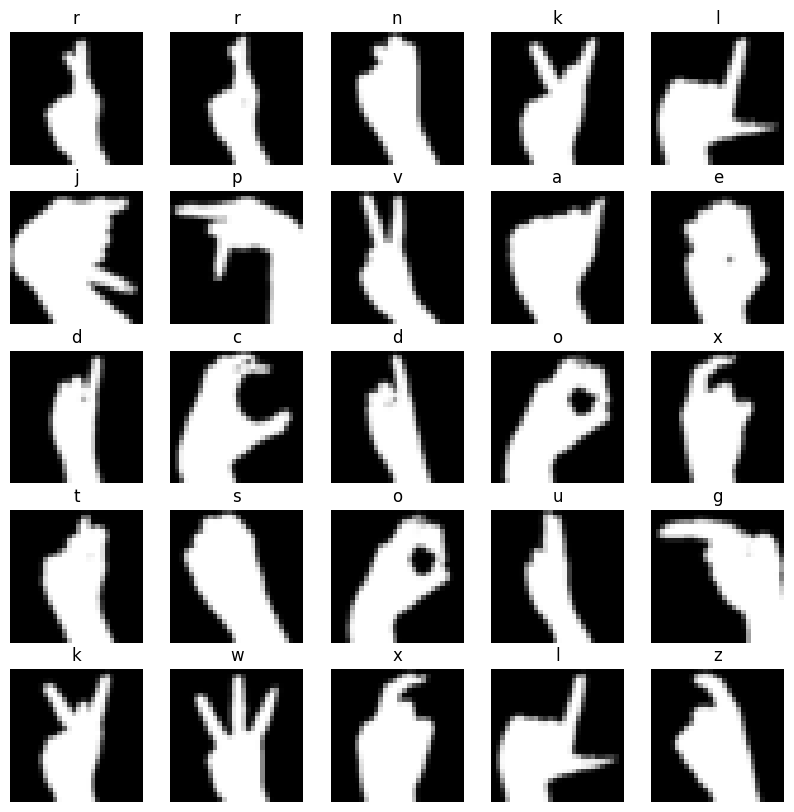

<Figure size 640x480 with 0 Axes>

In [9]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(5,5, images, targets, train_set.classes)

### Models and Training, for base dataset

In [10]:
# functions taken from notebook 09

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


def show_preds(set1, set2, count, title):
  
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(count, 2 * rows))
  
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off') 
      plt.suptitle(title, fontsize=16)  # Add this line to set the title for the entire figure


In [11]:
#CVAE (taken from notebook 11)
#Encoder
class Encoder(torch.nn.Module):

    def __init__(self, latent_space_dim):

        super().__init__()

        # encoder layers
        self.econv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size= 3, stride = 2)
        self.erelu1 = torch.nn.ReLU()
        self.ebn1 = torch.nn.BatchNorm2d(32)

        self.econv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3, stride = 2)
        self.erelu2 = torch.nn.ReLU()
        self.ebn2 = torch.nn.BatchNorm2d(64)

        self.efc1_mean = torch.nn.Linear(3136, latent_space_dim)
        self.efc1_log_var = torch.nn.Linear(3136, latent_space_dim)

    def forward(self, x):

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv1(x)
        x = self.ebn1(x)
        x = self.erelu1(x)

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv2(x)
        x = self.ebn2(x)
        x = self.erelu2(x)

        x = torch.flatten(x,1)
        mean = self.efc1_mean(x)
        log_var = self.efc1_log_var(x)

        return mean, log_var
    
#Decoder

class Decoder(torch.nn.Module):

    def __init__(self, latent_space_dim, condition_dim):
        
        super().__init__()

        self.dfc1 = torch.nn.Linear(latent_space_dim + condition_dim, 3136)
        
        self.dconvT1 = torch.nn.ConvTranspose2d(64, 32, 3, 2, padding = 1, output_padding=1)
        self.drelu1 = torch.nn.ReLU()
        self.dbn1 = torch.nn.BatchNorm2d(32)

        self.dconvT2 = torch.nn.ConvTranspose2d(32, 1,3,2, padding = 1, output_padding = 1)
        self.dsig = torch.nn.Sigmoid()


    def forward(self, x, condition):


        x = self.dfc1(torch.cat([x,condition],1))
        x = x.reshape(-1, 64, 7, 7)
        x = self.dconvT1(x)
        x = self.dbn1(x)
        x = self.drelu1(x)

        x = self.dconvT2(x)
        x = self.dsig(x)

        return x 
    
#CVAE

class CVAE(torch.nn.Module):

    def __init__(self, encoder, decoder):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, var):

        epsilon = torch.randn_like(mean).to(device)    
        z = mean + var * epsilon  
        return z  

    def forward(self, x,condition):

        mean, log_var = self.encoder(x)
        var = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, var)
        output = self.decoder(z, condition)

        return output, mean, log_var


In [12]:
# function taken from notebook 11
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)



def train_CVAE(model, train_loader, val_loader, condition_dim, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}

    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(train_loader, 0)):
            
            inputs = inputs.to(device)
            labels = one_hot(labels, condition_dim)
    
            outputs, mean, log_var = model(inputs, labels)
    
            loss = loss_fn(inputs, outputs, mean, log_var)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
     
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = one_hot(labels, condition_dim)
                outputs, mean, log_var = model(inputs, labels)
                
                #with torch.no_grad():
                val_loss += loss_fn(inputs, outputs, mean, log_var).cpu().detach().numpy()


        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Val Loss: {val_loss:0.6f}; Elapsed time: {(stop_time - start_time):0.4f}')

        history['val_loss'].append(val_loss)
        history['loss'].append(epoch_loss)
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'history': history,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')
            
            best_val_loss = val_loss
        
        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')
    
    return(history)


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_val_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False

In [13]:
LATENT_SPACE_DIMS = [2,4,8,16]
class_count = len(train_set.classes)
loss_functions_list = {}
MODELS_FOLDER = 'autoencoder_models'
os.makedirs(MODELS_FOLDER, exist_ok=True)

In [14]:
#################### LOSS FUNCTION 1 ####################
def loss_function_bce_kld(x, output, mean, log_var):
    BCE_loss = torch.nn.BCELoss(reduction = 'sum')
    reproduction_loss = BCE_loss(output, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

loss_functions_list['BCE+KLD'] = loss_function_bce_kld

#################### LOSS FUNCTION 2 ####################

def loss_function_mse_kld(x, output, mean, log_var):
    MSE_loss = torch.nn.MSELoss(reduction = 'sum')
    reproduction_loss = MSE_loss(output, x)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

loss_functions_list['MSE+KLD'] = loss_function_mse_kld

#################### LOSS FUNCTION 3 ####################

def loss_function_mae_kld(x, output, mean, log_var):
    reproduction_loss = torch.nn.functional.l1_loss(output, x, reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

loss_functions_list['MAE+KLD'] = loss_function_mae_kld
#################### LOSS FUNCTION 4 ####################

def loss_function_ce_kld(x, output, mean, log_var):
    CE_LOSS = torch.nn.CrossEntropyLoss(reduction='sum')
    reproduction_loss = CE_LOSS(output, x)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

loss_functions_list['CE+KLD'] = loss_function_ce_kld

In [15]:
print(loss_functions_list)
print(LATENT_SPACE_DIMS)

{'BCE+KLD': <function loss_function_bce_kld at 0x0000026A3D556B00>, 'MSE+KLD': <function loss_function_mse_kld at 0x0000026A3D556CB0>, 'MAE+KLD': <function loss_function_mae_kld at 0x0000026A3D556A70>, 'CE+KLD': <function loss_function_ce_kld at 0x0000026A3D5568C0>}
[2, 4, 8, 16]


In [118]:
for lossFn, loss_function in loss_functions_list.items():
    for LATENT_SPACE_DIM in LATENT_SPACE_DIMS:
        encoder = Encoder(LATENT_SPACE_DIM)
        decoder = Decoder(LATENT_SPACE_DIM, class_count)
        model = CVAE(encoder, decoder).to(device)
        model.to(device)
        model_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}'
        #torchinfo.summary(model, input_size=[(BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH), (BATCH_SIZE, class_count)], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"])
        
        optimizer = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
        early_stop = Early_Stopping(9)
        print(f'Loss function: {lossFn}, Latent space dim: {LATENT_SPACE_DIM}')
        history = train_CVAE(model, train_loader, validation_loader, class_count, EPOCHS, loss_function, optimizer, scheduler, early_stop, save_prefix = model_path)
        print(history.items())


Loss function: MSE+KLD, Latent space dim: 16


0it [00:00, ?it/s]

574it [00:20, 27.91it/s]


Epoch: 000; Loss: 32.072990; Val Loss: 18.833845; Elapsed time: 25.2964


574it [00:20, 27.81it/s]


Epoch: 001; Loss: 17.590252; Val Loss: 16.186120; Elapsed time: 25.6152


574it [00:21, 27.16it/s]


Epoch: 002; Loss: 15.387386; Val Loss: 14.451085; Elapsed time: 25.8593


574it [00:20, 27.59it/s]


Epoch: 003; Loss: 14.038588; Val Loss: 13.306441; Elapsed time: 25.5416


574it [00:20, 28.51it/s]


Epoch: 004; Loss: 13.127294; Val Loss: 12.517266; Elapsed time: 25.3099


574it [00:20, 27.66it/s]


Epoch: 005; Loss: 12.463476; Val Loss: 12.191687; Elapsed time: 25.4964


574it [00:21, 27.15it/s]


Epoch: 006; Loss: 11.998928; Val Loss: 11.792844; Elapsed time: 25.8623


574it [00:19, 29.58it/s]


Epoch: 007; Loss: 11.613689; Val Loss: 11.538480; Elapsed time: 23.9456


574it [00:20, 27.40it/s]


Epoch: 008; Loss: 11.302232; Val Loss: 11.297255; Elapsed time: 25.4409


574it [00:20, 28.61it/s]


Epoch: 009; Loss: 11.044914; Val Loss: 10.793014; Elapsed time: 24.7160
Finished Training
dict_items([('val_loss', [18.83384450422264, 16.186119791433754, 14.451084642823337, 13.306440598317353, 12.517265565839804, 12.191687167771239, 11.792844041934611, 11.53847989724852, 11.297255133381556, 10.793013536481997]), ('loss', [32.072989571526016, 17.590252456631767, 15.387386052513872, 14.038587683317083, 13.127294185220856, 12.463476288750137, 11.998927667470566, 11.613689011691493, 11.302232278989383, 11.044914226473756])])


### Losses And Validation Losses graphs per loss function, per latent space dimension, per epoch, per sample, for base models and dataset

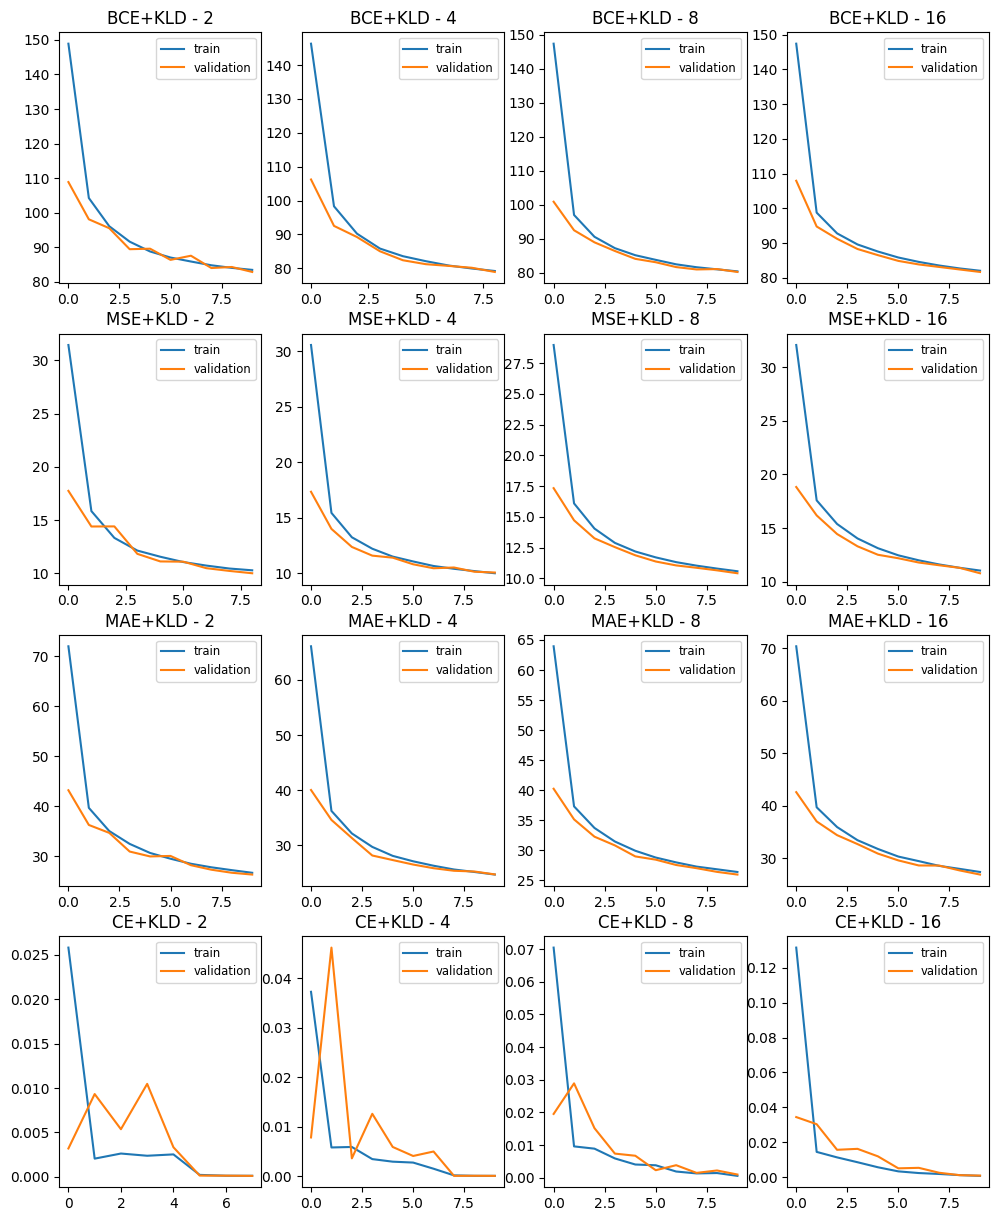

<Figure size 640x480 with 0 Axes>

In [16]:
f, axes= plt.subplots(loss_functions_list.__len__(), LATENT_SPACE_DIMS.__len__(), figsize=(12,15))
fig=plt.figure()

for i, (lossFn, loss_function) in enumerate(loss_functions_list.items()):
    for j, LATENT_SPACE_DIM in enumerate(LATENT_SPACE_DIMS):
        model_save_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}' + '_best.pt'
        reload = torch.load(model_save_path)
        history = reload['history']
        axes[i,j].plot(history['loss'], label='train')
        axes[i,j].plot(history['val_loss'], label='validation')
        axes[i,j].legend(loc='upper right', fontsize='small')
        axes[i,j].set_title(f'{lossFn} - {LATENT_SPACE_DIM}')
        
plt.show()

### Test Results for all models with different loss functions and latent space dimensions, for base models and dataset

9
8
9
9
8
9
9
9
9
9
9
9
7
9
9
9


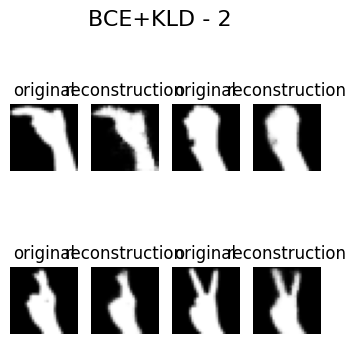

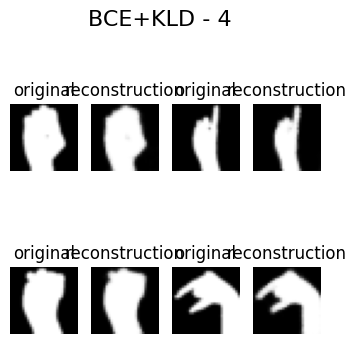

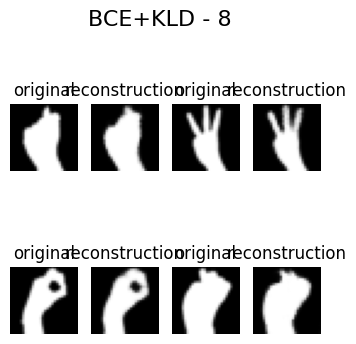

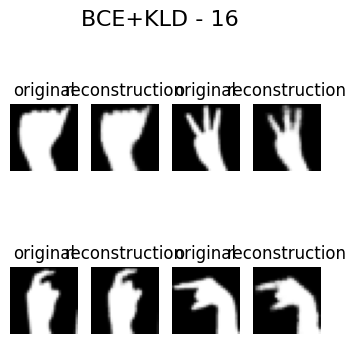

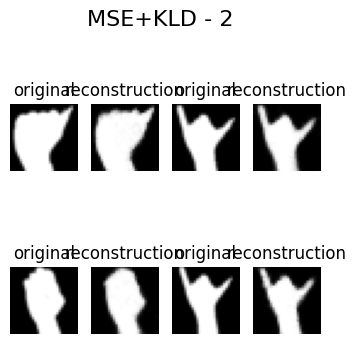

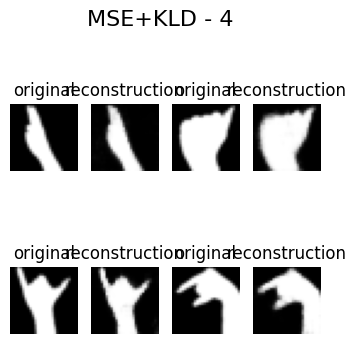

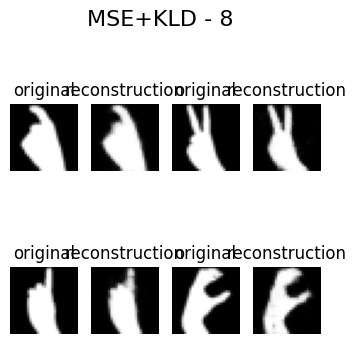

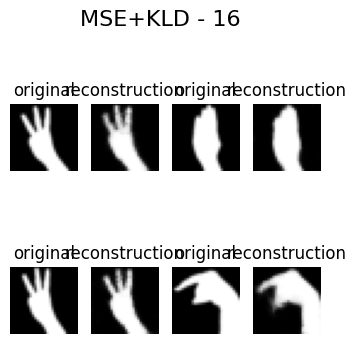

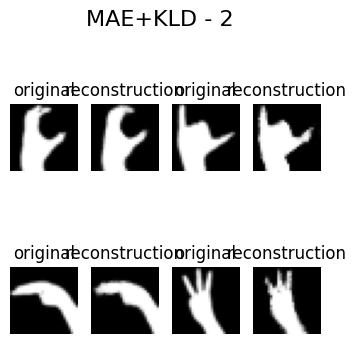

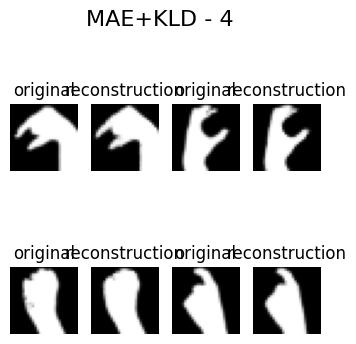

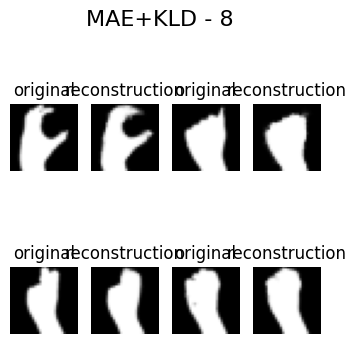

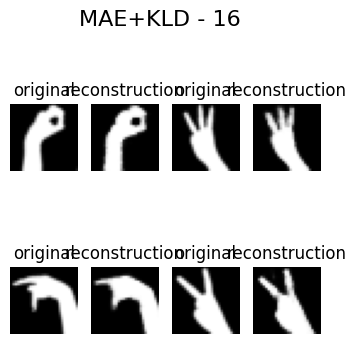

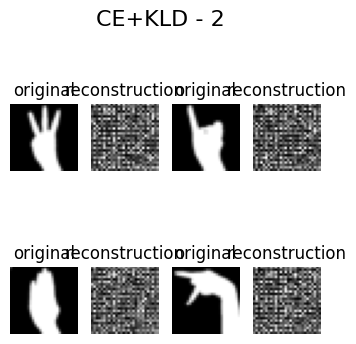

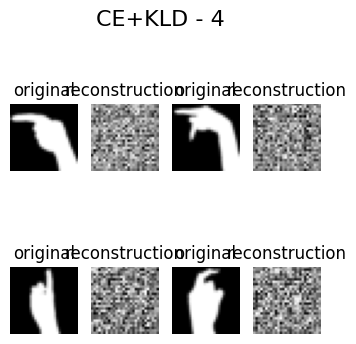

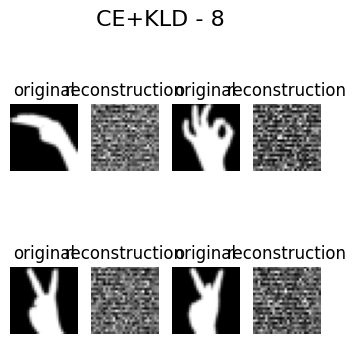

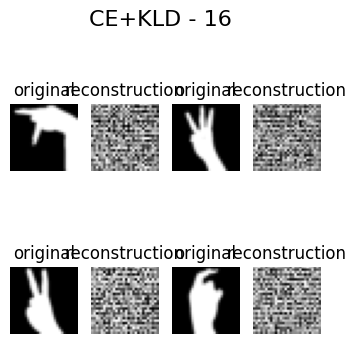

In [17]:
for lossFn, loss_function in loss_functions_list.items():
    for LATENT_SPACE_DIM in LATENT_SPACE_DIMS:
        model_save_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}' + '_best.pt'
        reload = torch.load(model_save_path)
        
        print(reload['epoch'])
        encoder = Encoder(LATENT_SPACE_DIM)
        decoder = Decoder(LATENT_SPACE_DIM, class_count)
        mCVAE = CVAE(encoder, decoder).to(device)
        mCVAE.to(device)
        mCVAE.load_state_dict(reload['model'])
        
        inputs, labels = next(iter(test_loader))
        recon = mCVAE(inputs.to(device), one_hot(labels, class_count))[0]
        show_preds(inputs, recon, 4, f'{lossFn} - {LATENT_SPACE_DIM}')

##### ADDING SALT AND PEPPER LIKE NOISE TO THE TEST IMAGES, for base models trained and validated with base dataset

9
8
9
9
8
9
9
9
9
9
9
9
7
9
9
9


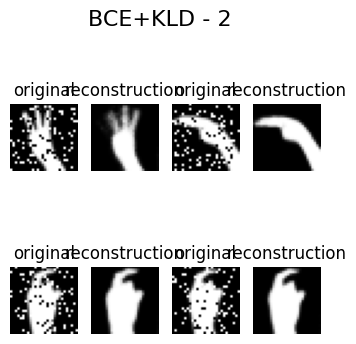

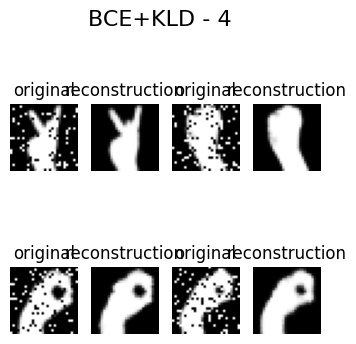

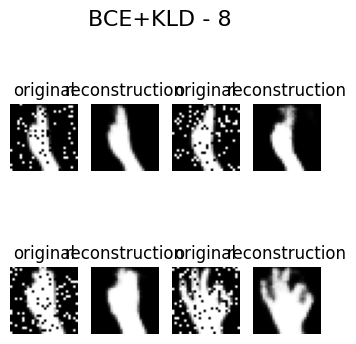

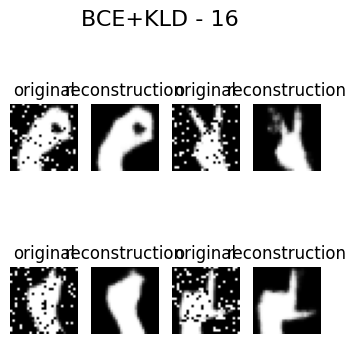

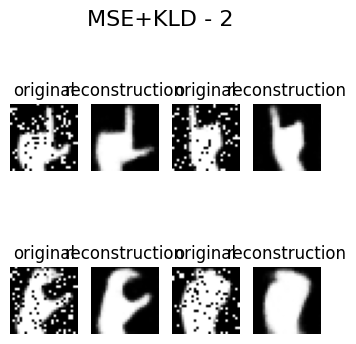

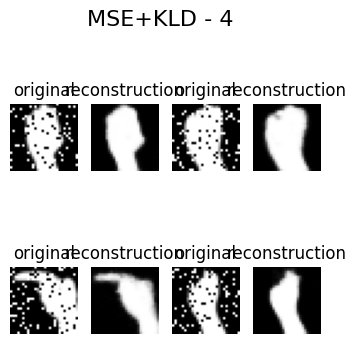

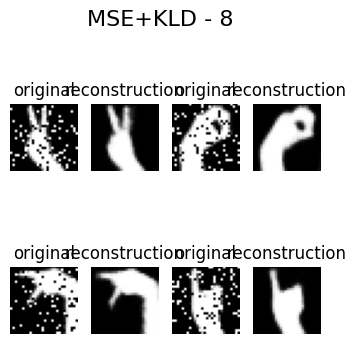

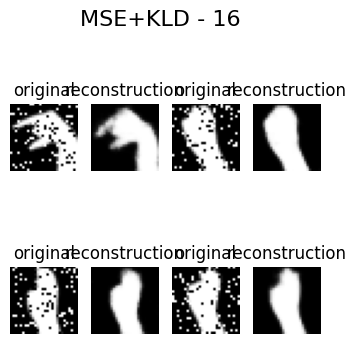

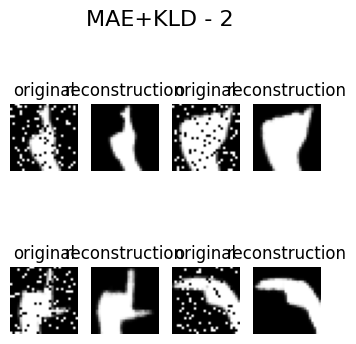

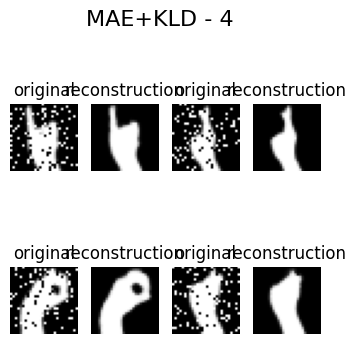

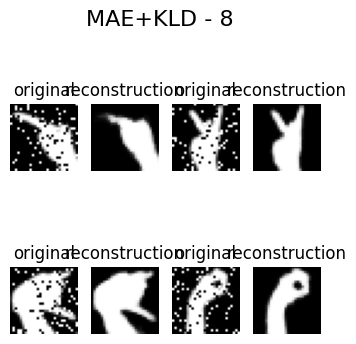

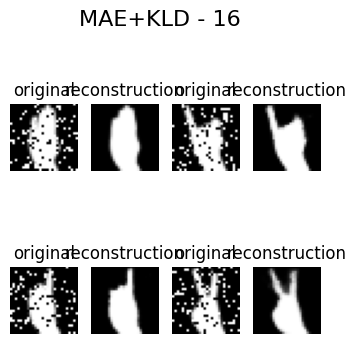

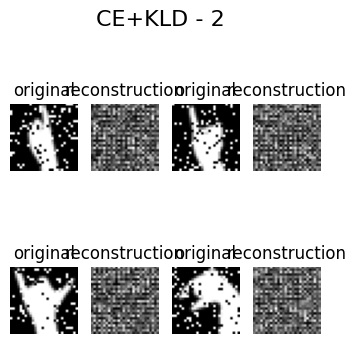

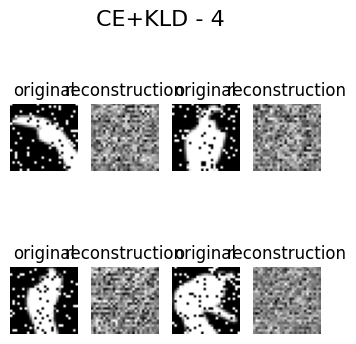

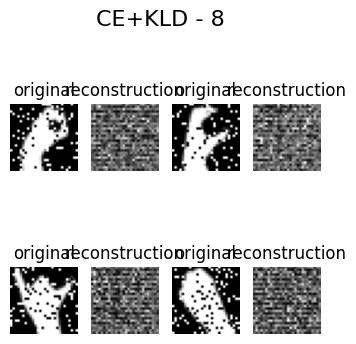

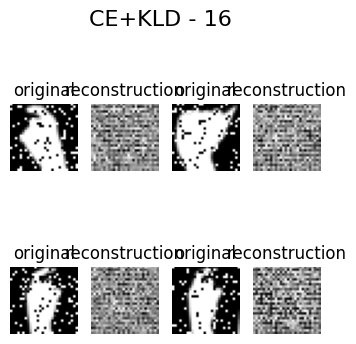

In [18]:
class AddSaltAndPepper(object):
    def __init__(self, amount=0.01):
        self.amount = amount

    def __call__(self, x):
        x_np = x.numpy()  # Convert PyTorch tensor to NumPy array
        noisy_image_np = skimage.util.random_noise(x_np, mode='pepper', amount=self.amount/2)
        noisy_image_np = skimage.util.random_noise(noisy_image_np, mode='salt', amount=self.amount/2)
        noisy_image = torch.from_numpy(noisy_image_np).float()  # Convert NumPy array back to PyTorch tensor
        return noisy_image


transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=NUM_CHANNELS),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor(),
    AddSaltAndPepper(amount=0.2)
])

test_set2 = torchvision.datasets.ImageFolder(root=test_path_dest, transform=transform2)
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=BATCH_SIZE, shuffle=True)

for lossFn, loss_function in loss_functions_list.items():
    for LATENT_SPACE_DIM in LATENT_SPACE_DIMS:
        model_save_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}' + '_best.pt'
        reload = torch.load(model_save_path)
        print(reload['epoch'])
        encoder = Encoder(LATENT_SPACE_DIM)
        decoder = Decoder(LATENT_SPACE_DIM, class_count)
        mCVAE = CVAE(encoder, decoder).to(device)
        mCVAE.to(device)
        mCVAE.load_state_dict(reload['model'])
        
        inputs, labels = next(iter(test_loader2))
        recon = mCVAE(inputs.to(device), one_hot(labels, class_count))[0]
        show_preds(inputs, recon, 4, f'{lossFn} - {LATENT_SPACE_DIM}')

##### ADDING ROTATIONS TO THE TEST IMAGES, for base models, trained and validated with base dataset

9
8
9
9
8
9
9
9
9
9
9
9
7
9
9
9


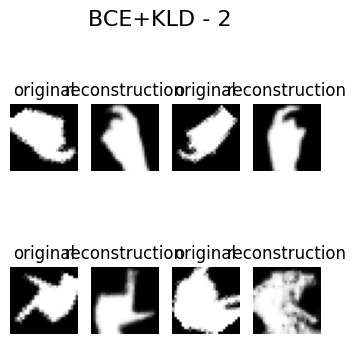

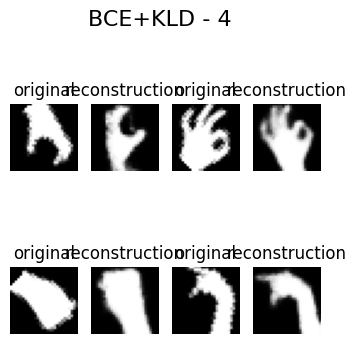

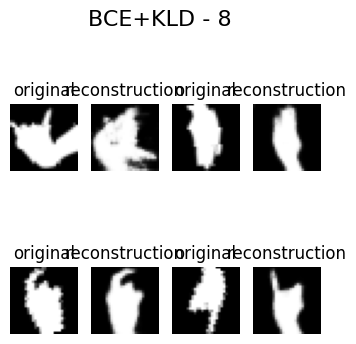

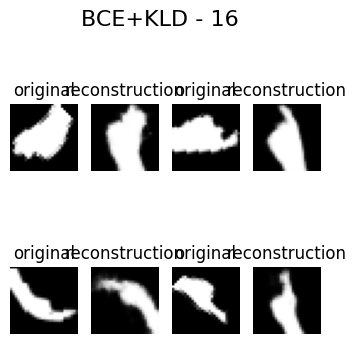

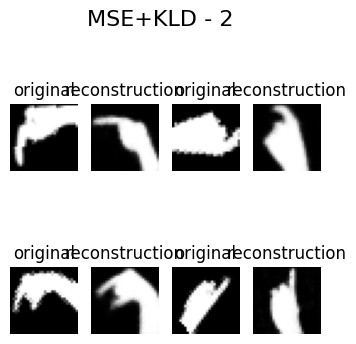

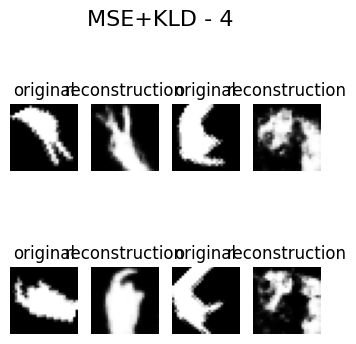

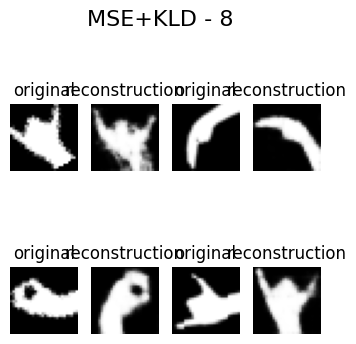

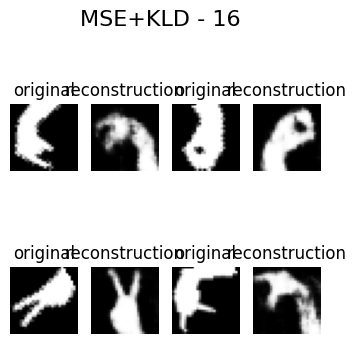

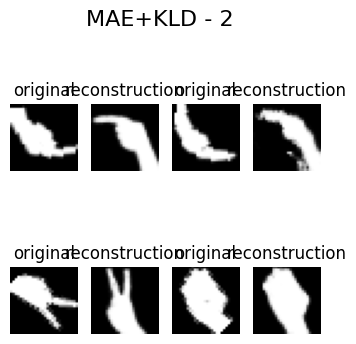

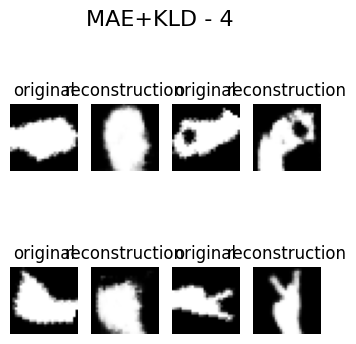

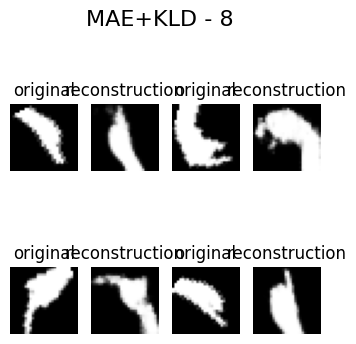

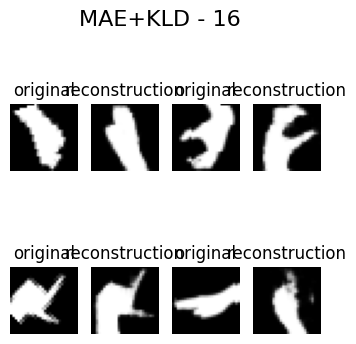

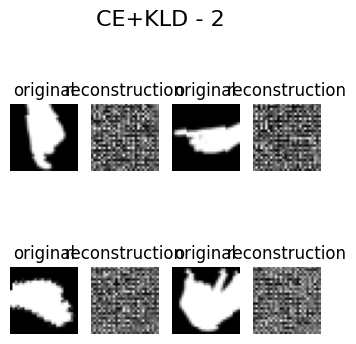

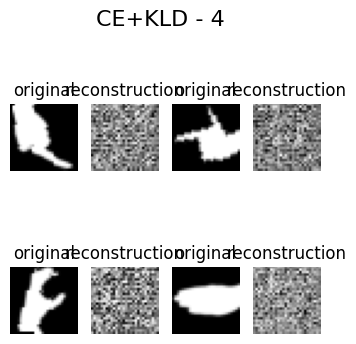

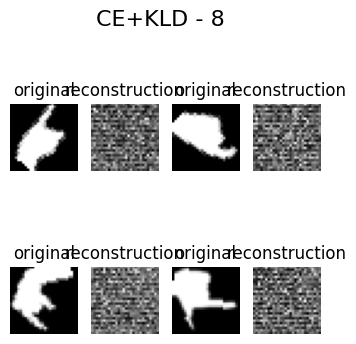

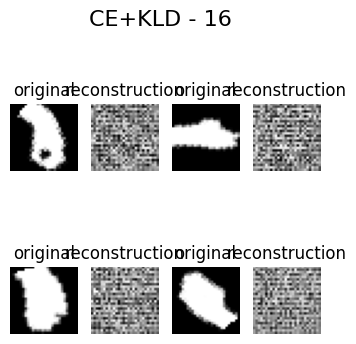

In [19]:
transform3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=NUM_CHANNELS),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.RandomRotation(270),
    transforms.ToTensor()
])

test_set3 = torchvision.datasets.ImageFolder(root=test_path_dest, transform=transform3)
test_loader3 = torch.utils.data.DataLoader(test_set3, batch_size=BATCH_SIZE, shuffle=True)

for lossFn, loss_function in loss_functions_list.items():
    for LATENT_SPACE_DIM in LATENT_SPACE_DIMS:
        model_save_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}' + '_best.pt'
        reload = torch.load(model_save_path)
        print(reload['epoch'])
        encoder = Encoder(LATENT_SPACE_DIM)
        decoder = Decoder(LATENT_SPACE_DIM, class_count)
        mCVAE = CVAE(encoder, decoder).to(device)
        mCVAE.to(device)
        mCVAE.load_state_dict(reload['model'])
        
        inputs, labels = next(iter(test_loader3))
        recon = mCVAE(inputs.to(device), one_hot(labels, class_count))[0]
        show_preds(inputs, recon, 4, f'{lossFn} - {LATENT_SPACE_DIM}')

# MANIPULATION OF THE DATASET

### Data Preparation for manipulated dataset

In [20]:
path_dest_man = os.path.join('dataset_man')
train_path_dest_man = os.path.join(path_dest_man, 'trainSet')
validation_path_dest_man = os.path.join(path_dest_man, 'validSet')
test_path_dest_man = os.path.join(path_dest_man, 'testSet')

In [40]:
# use create the dataset for this section, to train the model with added transformations
separate_dataset(DATASET_PATH, train_path_dest_man, validation_path_dest_man, test_path_dest_man, 0.7,0.2,0.1)

In [39]:
# use to remove the dataset for this section
remove_directories([path_dest_man])

In [21]:
# functions to add more images to the manipulated dataset
def add_rotation(file_path, new_file_path):
    if not os.path.exists(file_path):
        print('The dataset folder does not exist')
        return
    
    degrees = np.random.randint(10, 350)
    
    image = Image.open(file_path)
    image = image.rotate(degrees)
    image.save(new_file_path)
    
# max transform_split=1, min transform_split=0.
# more transformations can be added, and those functions should take the same arguments as add_rotation
# the transformation added to each image is randomly selected from the list of transformations    
def add_random_transform(data_path, transform_split = 0.5, transformations=[add_rotation]):
    if not os.path.exists(data_path):
        print('The dataset path does not exist')
        return
    
    if transform_split <= 0 or transform_split > 1:
        print('The split is less than or equal to 0 or greater than 1')
        return
    
    sets = os.listdir(data_path)
    
    for set_name in sets:
        set_name = os.path.join(data_path, set_name)
        classes = os.listdir(set_name)
        for class_name in classes:
            class_name = os.path.join(set_name, class_name)
            files = os.listdir(class_name)
            curr_num_files = len(files)
            curr_num_name = curr_num_files
            num_transform_files = int(curr_num_files * transform_split)
            for i in range(num_transform_files):
                file = files[np.random.randint(curr_num_files)]
                curr_num_files -= 1
                files.remove(file)
                file = os.path.join(class_name, file)
                fType = file.split('.')[-1]
                fName = str(curr_num_name + i) + '.' + fType
                fName = os.path.join(class_name, fName)
                
                transform = transformations[np.random.randint(len(transformations))]
                transform(file, fName)


In [41]:
# use this to increase the datasetwith more transformations
add_random_transform(path_dest_man, 0.5, [add_rotation])

In [42]:
transform_man = transforms.Compose([
    transforms.Grayscale(num_output_channels=NUM_CHANNELS),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor()
])

train_set_man = torchvision.datasets.ImageFolder(root=train_path_dest_man, transform=transform_man)
train_loader_man = torch.utils.data.DataLoader(train_set_man, batch_size=BATCH_SIZE, shuffle=True)

validation_set_man = torchvision.datasets.ImageFolder(root=validation_path_dest_man, transform=transform_man)
validation_loader_man = torch.utils.data.DataLoader(validation_set_man, batch_size=BATCH_SIZE)

test_set_man = torchvision.datasets.ImageFolder(root=test_path_dest_man, transform=transform_man)
test_loader_man = torch.utils.data.DataLoader(test_set_man, batch_size=BATCH_SIZE, shuffle=True)

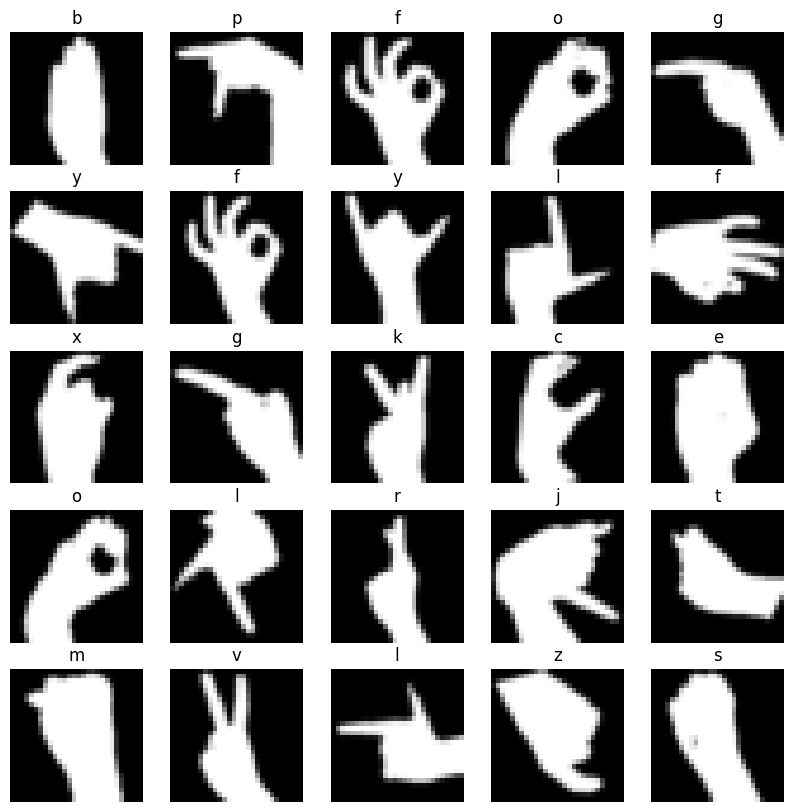

<Figure size 640x480 with 0 Axes>

In [43]:
images, targets = next(iter(train_loader_man))

vcpi_util.show_images(5,5, images, targets, train_set_man.classes) 

### Models Training for manipulated dataset

In [44]:
class_count_man = len(train_set_man.classes)
MODELS_FOLDER_man = os.path.join(MODELS_FOLDER, 'manipulated')
os.makedirs(MODELS_FOLDER_man, exist_ok=True)
lossFn_man = 'MSE+KLD'
loss_function_man = loss_function_mse_kld

print(class_count_man)
print(MODELS_FOLDER_man)
print(LATENT_SPACE_DIMS)

26
autoencoder_models\manipulated
[2, 4, 8, 16]


In [190]:
for lat_dim_man in LATENT_SPACE_DIMS:
    encoder_man = Encoder(lat_dim_man)
    decoder_man = Decoder(lat_dim_man, class_count_man)
    model_man = CVAE(encoder_man, decoder_man).to(device)
    model_man.to(device)
    model_path_man = f'{MODELS_FOLDER_man}/CVAE_model_lossFn={lossFn_man}_latentDim{lat_dim_man}_condition{class_count_man}_manipulated_datasets'

    
    optimizer_man = torch.optim.Adam(model_man.parameters())
    scheduler_man = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_man, mode='min', factor = 0.1, patience=3)


    early_stop_man = Early_Stopping(9)
    print(f'Loss function: {lossFn_man}, Latent space dim: {lat_dim_man}')
    history_man = train_CVAE(model_man, train_loader_man, validation_loader_man, class_count_man, EPOCHS, loss_function_man, optimizer_man, scheduler_man, early_stop_man, save_prefix = model_path_man)
    print(history_man.items())

Loss function: MSE+KLD, Latent space dim: 2


860it [01:53,  7.57it/s]


Epoch: 000; Loss: 46.194741; Val Loss: 36.797731; Elapsed time: 144.2984


860it [00:29, 29.33it/s]


Epoch: 001; Loss: 33.791245; Val Loss: 31.640717; Elapsed time: 36.2686


860it [00:29, 29.40it/s]


Epoch: 002; Loss: 30.433650; Val Loss: 29.178135; Elapsed time: 36.0387


860it [00:28, 29.83it/s]


Epoch: 003; Loss: 28.362885; Val Loss: 27.930603; Elapsed time: 35.6695


860it [00:30, 28.34it/s]


Epoch: 004; Loss: 26.935895; Val Loss: 26.638753; Elapsed time: 37.0916


860it [00:32, 26.25it/s]


Epoch: 005; Loss: 25.953585; Val Loss: 26.074147; Elapsed time: 39.8411


860it [00:32, 26.40it/s]


Epoch: 006; Loss: 25.174495; Val Loss: 24.969469; Elapsed time: 39.6177


860it [00:25, 33.15it/s]


Epoch: 007; Loss: 24.478238; Val Loss: 24.335372; Elapsed time: 32.3246


860it [00:28, 29.77it/s]


Epoch: 008; Loss: 23.927151; Val Loss: 24.162535; Elapsed time: 35.6529


860it [00:32, 26.36it/s]


Epoch: 009; Loss: 23.467484; Val Loss: 23.662139; Elapsed time: 39.4657
Finished Training
dict_items([('val_loss', [36.79773106834024, 31.640716525559327, 29.178134562510934, 27.93060344661591, 26.638753155566494, 26.074147396090073, 24.969468861526394, 24.33537242400739, 24.162534963415865, 23.66213909479638]), ('loss', [46.19474138564054, 33.79124460887174, 30.433650359907787, 28.36288486530067, 26.935895007854803, 25.953584569261974, 25.17449475374484, 24.478237655069577, 23.927151292506164, 23.467484424411946])])
Loss function: MSE+KLD, Latent space dim: 4


860it [00:29, 29.14it/s]


Epoch: 000; Loss: 43.257773; Val Loss: 30.305854; Elapsed time: 36.3538


860it [00:32, 26.65it/s]


Epoch: 001; Loss: 28.165720; Val Loss: 26.099246; Elapsed time: 39.2853


860it [00:31, 27.48it/s]


Epoch: 002; Loss: 25.284947; Val Loss: 24.127619; Elapsed time: 38.3767


860it [00:28, 30.50it/s]


Epoch: 003; Loss: 23.750711; Val Loss: 23.551662; Elapsed time: 35.1274


860it [00:30, 28.38it/s]


Epoch: 004; Loss: 22.723365; Val Loss: 22.364681; Elapsed time: 37.1683


860it [00:27, 30.76it/s]


Epoch: 005; Loss: 22.002121; Val Loss: 21.840139; Elapsed time: 34.8237


860it [00:28, 30.58it/s]


Epoch: 006; Loss: 21.497773; Val Loss: 21.541220; Elapsed time: 34.8771


860it [00:27, 31.10it/s]


Epoch: 007; Loss: 20.999434; Val Loss: 21.367825; Elapsed time: 34.3588


860it [00:28, 29.70it/s]


Epoch: 008; Loss: 20.615568; Val Loss: 20.747929; Elapsed time: 35.6229


860it [00:32, 26.80it/s]


Epoch: 009; Loss: 20.301291; Val Loss: 20.365811; Elapsed time: 38.9453
Finished Training
dict_items([('val_loss', [30.30585351528337, 26.099246180492752, 24.127618723433674, 23.551662412555356, 22.364680959043756, 21.840138851602998, 21.54121983383406, 21.367825185777942, 20.747928908119643, 20.365810781046264]), ('loss', [43.257772892362624, 28.16571999622095, 25.284946626313015, 23.750711043155857, 22.723364903078053, 22.002121060406473, 21.497773362481503, 20.999434130502692, 20.615568440222848, 20.301291076331868])])
Loss function: MSE+KLD, Latent space dim: 8


860it [00:32, 26.57it/s]


Epoch: 000; Loss: 41.003759; Val Loss: 29.789978; Elapsed time: 39.3621


860it [00:32, 26.43it/s]


Epoch: 001; Loss: 27.877628; Val Loss: 26.259458; Elapsed time: 39.5403


860it [00:32, 26.56it/s]


Epoch: 002; Loss: 25.294896; Val Loss: 24.373694; Elapsed time: 39.2555


860it [00:32, 26.65it/s]


Epoch: 003; Loss: 23.979900; Val Loss: 23.557615; Elapsed time: 39.2486


860it [00:32, 26.49it/s]


Epoch: 004; Loss: 23.018745; Val Loss: 22.816692; Elapsed time: 39.3372


860it [00:32, 26.71it/s]


Epoch: 005; Loss: 22.434943; Val Loss: 22.146337; Elapsed time: 39.1404


860it [00:32, 26.76it/s]


Epoch: 006; Loss: 21.902465; Val Loss: 21.644389; Elapsed time: 39.0263


860it [00:32, 26.74it/s]


Epoch: 007; Loss: 21.459320; Val Loss: 21.295654; Elapsed time: 39.1215


860it [00:32, 26.60it/s]


Epoch: 008; Loss: 21.101391; Val Loss: 21.186393; Elapsed time: 39.1893


860it [00:32, 26.79it/s]


Epoch: 009; Loss: 20.771975; Val Loss: 20.852017; Elapsed time: 39.1382
Finished Training
dict_items([('val_loss', [29.789977670185987, 26.25945822086487, 24.373693912876362, 23.55761477668509, 22.81669215867271, 22.146337051304254, 21.644388534415846, 21.295654029006677, 21.186392616822268, 20.85201718900938]), ('loss', [41.00375948702289, 27.877628411261004, 25.294896232958777, 23.97990041500712, 23.01874547005393, 22.434942790875862, 21.902465012898745, 21.45931955263493, 21.10139095452241, 20.7719746592572])])
Loss function: MSE+KLD, Latent space dim: 16


860it [00:32, 26.46it/s]


Epoch: 000; Loss: 43.847380; Val Loss: 32.234046; Elapsed time: 39.4536


860it [00:32, 26.43it/s]


Epoch: 001; Loss: 30.162884; Val Loss: 28.303145; Elapsed time: 39.5443


860it [00:32, 26.44it/s]


Epoch: 002; Loss: 27.470353; Val Loss: 26.443426; Elapsed time: 39.4619


860it [00:32, 26.47it/s]


Epoch: 003; Loss: 25.823737; Val Loss: 25.368611; Elapsed time: 39.4392


860it [00:32, 26.46it/s]


Epoch: 004; Loss: 24.725287; Val Loss: 24.200924; Elapsed time: 39.3807


860it [00:32, 26.37it/s]


Epoch: 005; Loss: 23.806387; Val Loss: 23.530023; Elapsed time: 39.5324


860it [00:32, 26.32it/s]


Epoch: 006; Loss: 23.207691; Val Loss: 22.988176; Elapsed time: 39.5864


860it [00:32, 26.47it/s]


Epoch: 007; Loss: 22.628366; Val Loss: 22.558796; Elapsed time: 39.4692


860it [00:32, 26.37it/s]


Epoch: 008; Loss: 22.169464; Val Loss: 22.233032; Elapsed time: 39.4926


860it [00:32, 26.43it/s]


Epoch: 009; Loss: 21.848363; Val Loss: 21.838612; Elapsed time: 39.4122
Finished Training
dict_items([('val_loss', [32.234045902412824, 28.30314465221778, 26.443426287730766, 25.36861108814604, 24.200924042450715, 23.530022584638317, 22.988176358199546, 22.558795804241022, 22.233031772350994, 21.838611602297934]), ('loss', [43.84738034296736, 30.162883784608415, 27.47035272295764, 25.82373748038428, 24.72528656001423, 23.806386597992844, 23.20769086600147, 22.628365883908312, 22.169463869547634, 21.84836291559804])])


### Training loss and Validation loss graphs per latent space dimention

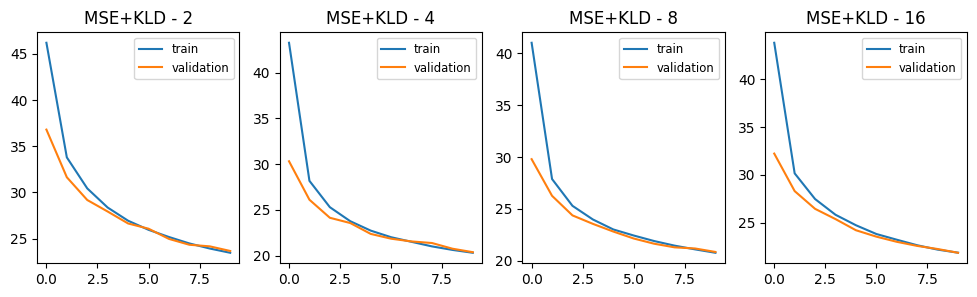

<Figure size 640x480 with 0 Axes>

In [45]:
f, axes= plt.subplots(1, LATENT_SPACE_DIMS.__len__(), figsize=(12,3))
fig=plt.figure()

for i, lat_dim_man in enumerate(LATENT_SPACE_DIMS):
    model_path_man = f'{MODELS_FOLDER_man}/CVAE_model_lossFn={lossFn_man}_latentDim{lat_dim_man}_condition{class_count_man}_manipulated_datasets_best.pt'
    reload = torch.load(model_path_man)
    history = reload['history']
    axes[i].plot(history['loss'], label='train')
    axes[i].plot(history['val_loss'], label='validation')
    axes[i].legend(loc='upper right', fontsize='small')
    axes[i].set_title(f'{lossFn_man} - {lat_dim_man}')
        
plt.show()

### Test results for manipulated dataset, using models trained with manipulated dataset

9
9
9
9


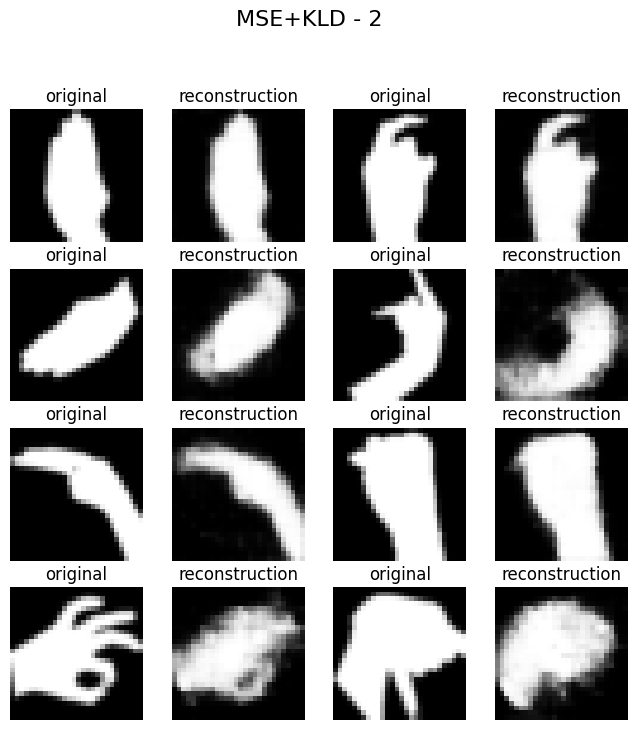

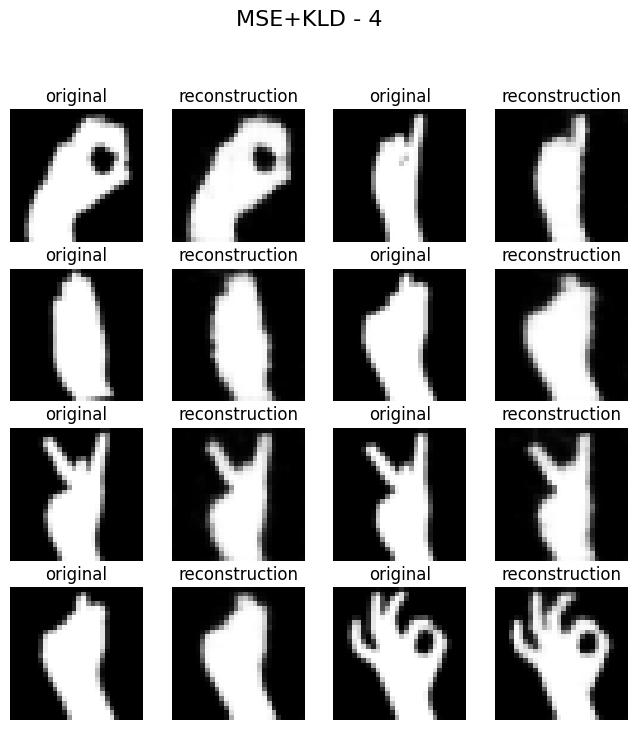

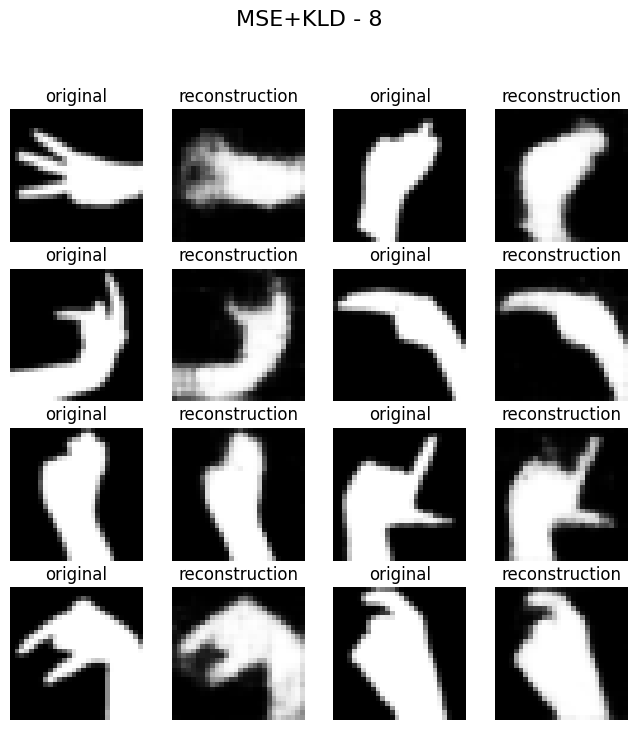

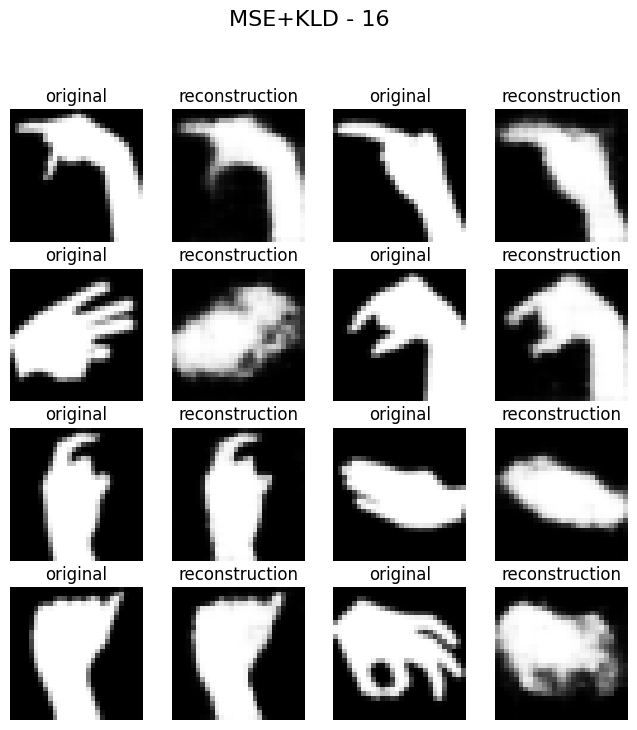

In [48]:
for lat_dim_man in LATENT_SPACE_DIMS:
    model_path_man = f'{MODELS_FOLDER_man}/CVAE_model_lossFn={lossFn_man}_latentDim{lat_dim_man}_condition{class_count_man}_manipulated_datasets_best.pt'
    reload = torch.load(model_path_man)
        
    print(reload['epoch'])
    encoder = Encoder(lat_dim_man)
    decoder = Decoder(lat_dim_man, class_count_man)
    mCVAE = CVAE(encoder, decoder).to(device)
    mCVAE.to(device)
    mCVAE.load_state_dict(reload['model'])
        
    inputs, labels = next(iter(test_loader_man))
    recon = mCVAE(inputs.to(device), one_hot(labels, class_count_man))[0]
    show_preds(inputs, recon, 8, f'{lossFn_man} - {lat_dim_man}')

##### ADDING SALT AND PEPPER LIKE NOISE TO THE TEST IMAGES, for models trained and validated with manipulated dataset

9
9
9
9


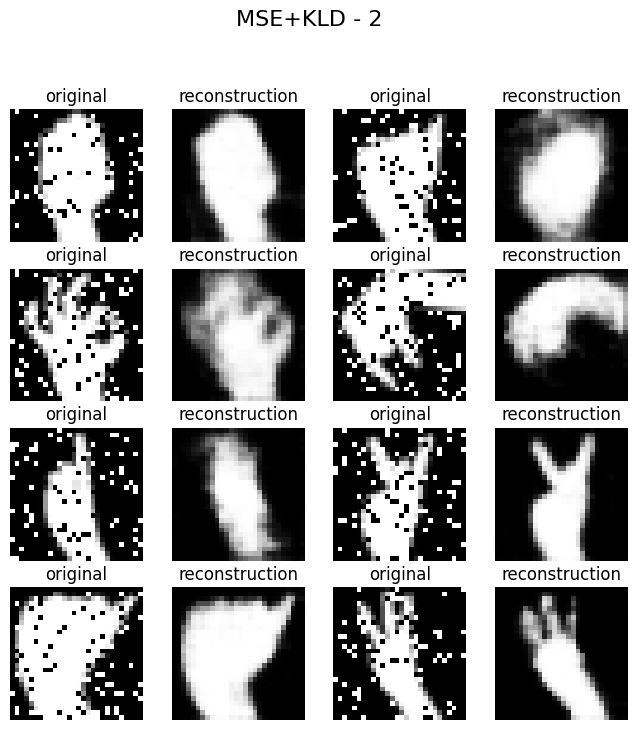

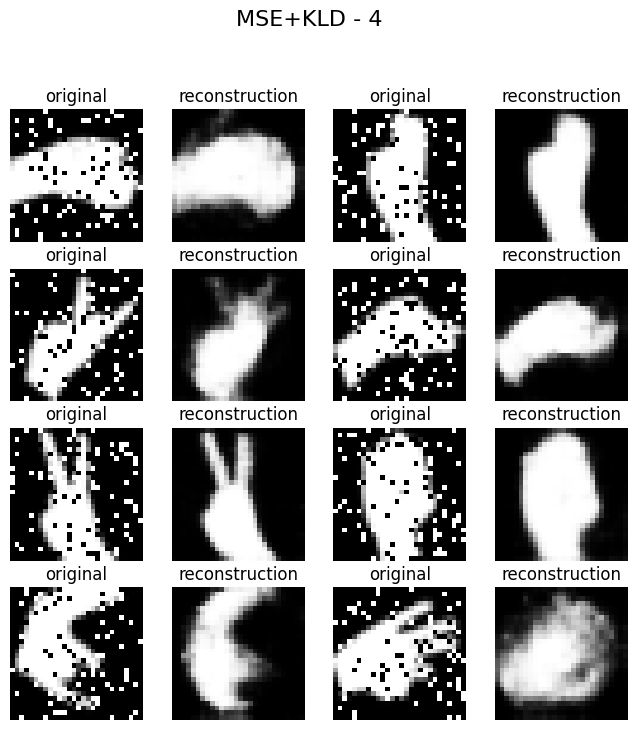

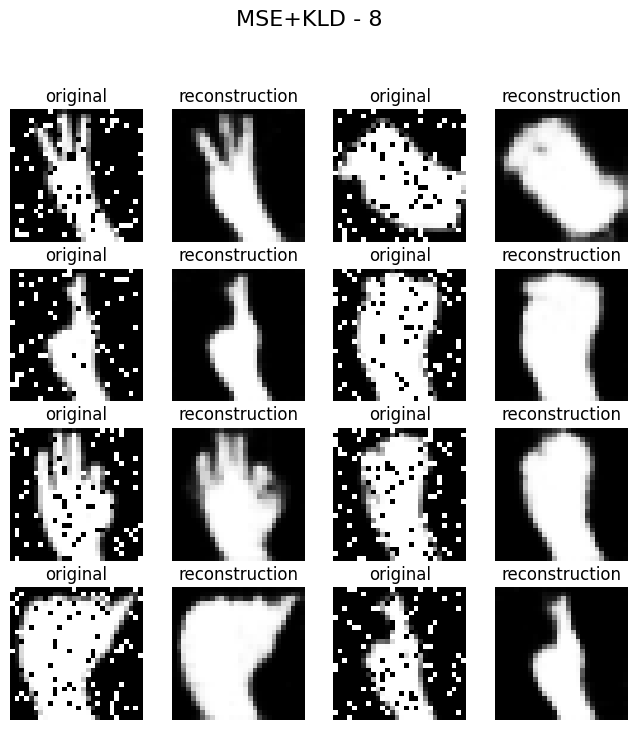

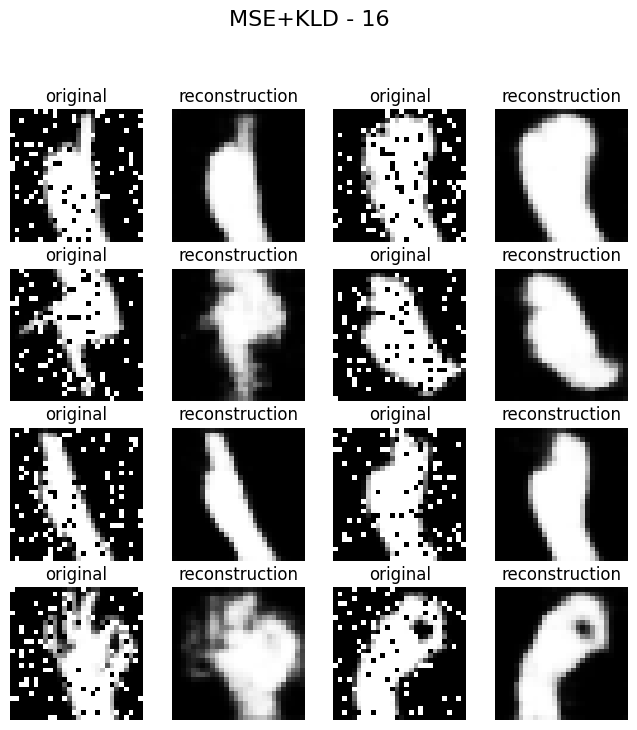

In [47]:
transform_man2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=NUM_CHANNELS),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor(),
    AddSaltAndPepper(amount=0.2)
])

test_set_man2 = torchvision.datasets.ImageFolder(root=test_path_dest_man, transform=transform_man2)
test_loader_man2 = torch.utils.data.DataLoader(test_set_man2, batch_size=BATCH_SIZE, shuffle=True)

for lat_dim_man in LATENT_SPACE_DIMS:
    model_path_man = f'{MODELS_FOLDER_man}/CVAE_model_lossFn={lossFn_man}_latentDim{lat_dim_man}_condition{class_count_man}_manipulated_datasets_best.pt'
    reload = torch.load(model_path_man)
        
    print(reload['epoch'])
    encoder = Encoder(lat_dim_man)
    decoder = Decoder(lat_dim_man, class_count_man)
    mCVAE = CVAE(encoder, decoder).to(device)
    mCVAE.to(device)
    mCVAE.load_state_dict(reload['model'])
        
    inputs, labels = next(iter(test_loader_man2))
    recon = mCVAE(inputs.to(device), one_hot(labels, class_count_man))[0]
    show_preds(inputs, recon, 8, f'{lossFn_man} - {lat_dim_man}')

# COMBINED DATASETS